# Implement semantic video search in 5 minutes

We'll implement a **naive** semantic video search using OpenAI's [CLIP](https://github.com/openai/CLIP) model (ignoring audio for now).

In [20]:
from pathlib import Path

import clip
import cv2
import matplotlib.pyplot as plt
import torch
from PIL import Image
from tqdm import tqdm

torch.set_printoptions(sci_mode=False)

data_dir = Path("data_dir")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # will download ~340mb model

## Use [CLIP](https://github.com/openai/CLIP) to encode images and text into the same vector space

- CLIP can take an image and turn it into a vector of size 512
- CLIP can take a piece of text and turn it into a vector of size 512
- If the text and image are similar, their vectors will be "similar" 
    - (via cosine similarity - i.e. the vectors should be pointing in a similar direction)
- Here's an example:

### Turn an image and some pieces of text into vectors:

In [3]:
image = preprocess(Image.open("dog.jpeg")).unsqueeze(0).to(device)
dog_text = clip.tokenize(["a photo of a dog"]).to(device)
cat_text = clip.tokenize(["a photo of a cat"]).to(device)
misc_text = clip.tokenize(["red green yellow"]).to(device)
with torch.no_grad():
    image_vector = model.encode_image(image)
    dog_text_vector = model.encode_text(dog_text)
    cat_text_vector = model.encode_text(cat_text)
    misc_text_vector = model.encode_text(misc_text)
print(f"{image_vector.shape = }")
print(f"{dog_text_vector.shape = }")
print(f"{cat_text_vector.shape = }")
print(f"{misc_text_vector.shape = }")

image_vector.shape = torch.Size([1, 512])
dog_text_vector.shape = torch.Size([1, 512])
cat_text_vector.shape = torch.Size([1, 512])
misc_text_vector.shape = torch.Size([1, 512])


In [4]:
dog_similarity = torch.cosine_similarity(image_vector, dog_text_vector).item()
cat_similarity = torch.cosine_similarity(image_vector, cat_text_vector).item()
misc_similarity = torch.cosine_similarity(image_vector, misc_text_vector).item()
print(f"dog similarity: {dog_similarity:.2f}")
print(f"cat similarity: {cat_similarity:.2f}")
print(f"misc similarity: {misc_similarity:.2f}")

dog similarity: 0.28
cat similarity: 0.20
misc similarity: 0.20


Note that "dog similarity" has the highest value, which is what we would hope for since the image is of a dog. 

But do the cat and misc values seem low enough compared to the dog value? 

Well, looking at the [CLIP codebase](https://github.com/openai/CLIP/blob/d50d76daa670286dd6cacf3bcd80b5e4823fc8e1/clip/model.py#L367) we can see that a softmax with a temperature parameter (i.e. `logit_scale`) is used on the cosine similarities, like this:

In [5]:
logit_scale = model.logit_scale.exp().item()
distances = logit_scale * torch.tensor(
    [dog_similarity, cat_similarity, misc_similarity]
)
softmaxed_distances = distances.exp() / distances.exp().sum()
print(f"{logit_scale = }")
print(f"{softmaxed_distances = }")
for x, distance in zip(["dog", "cat", "misc"], softmaxed_distances):
    print(f"{x} similarity: {distance.item():.4f}")

logit_scale = 100.0
softmaxed_distances = tensor([    0.9990,     0.0005,     0.0005])
dog similarity: 0.9990
cat similarity: 0.0005
misc similarity: 0.0005


So we can see that the model is pretty certain that "a photo of a dog" is the best of the options it was presented with to describe the image.

Now, how could we use this technology to carry out semantic search over video?...

In [6]:
# image = preprocess(Image.open("dog.jpeg")).unsqueeze(0).to(device)
# options = ["a photo of a dog", "a photo of a cat", "red green yellow"]
# texts = clip.tokenize(options).to(device)

# with torch.no_grad():
#     image_vectors = model.encode_image(image)
#     text_vectors = model.encode_text(texts)
#     logits_per_image, logits_per_text = model(image, texts)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print(image_vectors.shape)
# print(text_vectors.shape)
# print("Label probs:", probs)
# print(f"The most likely option is '{options[probs.argmax()]}'.")

## Download a video

We'll grab a video that has varied visual content (since we're ignoring audio).

In [7]:
video_path = data_dir / 'buster_keaton.mp4'
if not video_path.is_file():
    !yt-dlp -f 133 -o {video_path}  \
        'https://www.youtube.com/watch?v=frYIj2FGmMA'

## Convert the video into CLIP vectors

We can use [OpenCV](https://opencv.org/) (cv2) to process the video.

In [8]:
cap = cv2.VideoCapture(str(video_path))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"{frame_count = }")
print(f"{fps = }")
print(
    f"video size: {cap.get(cv2.CAP_PROP_FRAME_WIDTH):.0f}w {cap.get(cv2.CAP_PROP_FRAME_HEIGHT):.0f}h"
)

frame_count = 7465
fps = 24
video size: 426w 240h


Let's iterate through all frames in the video, and convert them into CLIP vectors.

In [9]:
image_vectors = torch.zeros((frame_count, 512), device=device)
for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    with torch.no_grad():
        image_vectors[i] = model.encode_image(
            preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
        )

100%|██████████| 7465/7465 [01:19<00:00, 94.09it/s] 


In [19]:
def get_most_similar_frames(query: str, k: int = 1) -> list[int]:
    query_vector = model.encode_text(clip.tokenize([query]).to(device))
    similarities = torch.cosine_similarity(image_vectors, query_vector)
    indices = similarities.topk(k).indices.cpu().numpy()
    return indices

def get_most_similar_frames(query: str) -> int:
    query_vector = model.encode_text(clip.tokenize([query]).to(device))
    similarities = torch.cosine_similarity(image_vectors, query_vector)
    index = similarities.argmax().item()
    return index

get_most_similar_frames("Man hanging from a boom barrier")

array([2061])

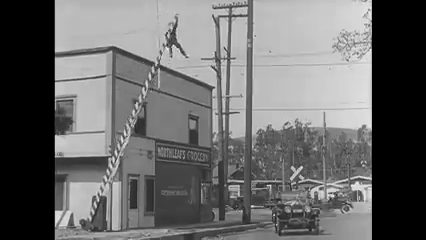

In [26]:
frames = get_most_similar_frames("Man hanging from a boom barrier")
cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0])
ret, frame = cap.read()
display(Image.fromarray(frame))